# Lab Data

Utilities and results of looking for sensor artifacts in lab data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path
from os import listdir

In [3]:
import matplotlib.patheffects
import mpl_toolkits.axes_grid.inset_locator

In [4]:
import fitsio
import numpy

In [5]:
import numpy.lib.stride_tricks

In [6]:
import scipy.stats
from scipy import interpolate
from scipy import signal
from scipy.stats import binned_statistic

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from pylab import *

In [8]:
import glob

In [9]:
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column

## Utilities

In [10]:
def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] %s does not evenly divide array shape[0].%s'%(block_shape[0], A.shape[0])
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] %s does not evenly divide array shape[1].%s'%(block_shape[1], A.shape[1])
    shape = (A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

In [11]:
def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    #if smoothing>0:
    #    S=S
    #else:
    #    S[:ny, :nx] = np.fft.irfft2(T * F*kpow/((1./250)**power+kpow))
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

In [1262]:
def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask

In [1263]:
def equalize(A, clip_percent=10.):
    """Equalize the values of an array.
    
    The returned array has values between 0-1 such that clip_percent
    of the values are clipped symmetrically at 0 and 1, and the
    histogram of values between 0 and 1 is flat. This is a non-linear
    transformation and primarily useful for showing small variations
    over a large dynamic range.
    """
    A_flat = A.reshape(-1)
    n = len(A_flat)
    num_clip = round(n * clip_percent / 100.)
    num_clip_lo = num_clip // 2
    num_clip_hi = num_clip - num_clip_lo
    equalized = np.empty_like(A_flat, dtype=float)
    order = np.argsort(A_flat)
    equalized[order] = np.clip(
        (np.arange(n) - num_clip_lo) / float(n - num_clip), 0., 1.)
    return equalized.reshape(A.shape)

In [1264]:
def downsample(data, mask, downsampling):
    """Downsample a masked image by the specified integer factor.
    
    The returned data is the average of unmasked input pixel values
    within each downsampled block.  The returned mask selects downsampled
    blocks with at least one unmasked input pixel.
    """
    downsampling = int(downsampling)
    assert downsampling > 0, 'Expected downsampling > 0.'
    npix = block_view(mask, (downsampling, downsampling)).sum(axis=(2, 3))
    mask = npix > 0
    data = block_view(data, (downsampling, downsampling)).sum(axis=(2, 3))
    data[mask] /= npix[mask]
    return data, mask

In [1265]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [ ]:
import numpy as np
import scipy.fftpack

N = 100
x = np.linspace(0,2*np.pi,N)
y = np.sin(x) + np.random.random(N) * 0.2

w = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
spectrum = w**2
print spectrum.max()
cutoff_idx = spectrum < (spectrum.max()/5)
w2 = w.copy()
w2[cutoff_idx] = 0

y2 = scipy.fftpack.irfft(w2)
plot(x,y,'k-')
plot(x,y2,'k-')

In [812]:
def plot_peaks_lows_highs(x, highs, lows, algorithm=None, mph=None, mpd=None):
    """Plot results of the peak dectection."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
        return
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if highs.size:
        label = 'high peak'
        label = label + 's' if highs.size > 1 else label
        ax.plot(highs, x[highs], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (highs.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    if lows.size:
        label = 'low peak'
        label = label + 's' if lows.size > 1 else label
        ax.plot(lows, x[lows], '+', mfc=None, mec='g', mew=2, ms=8,
                label='%d %s' % (lows.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s (mph=%s, mpd=%s)' % (algorithm, mph, mpd))
    plt.show()

threshold = 0.00002
min_dist = 150

In [1915]:
def measure_profile(data, mask, levels, idnumber,w_label, die, rradius,line_start, line_stop, sigma=50, num_bins=2000):
    """Measure a 1D profile along a line through 2D data.
    
    The sigma parameter determines the effective width of the measurement line
    in units of pixels, and is used to apply Gaussian weights as a function of
    transverse distance from the line. Returns a pair of functions to draw the
    measurement line and measured profile.
    """
    
    level=np.median(levels)
    x1, y1 = line_start
    x2, y2 = line_stop
    dx, dy = x2 - x1, y2 - y1
    dr = np.sqrt(dx ** 2 + dy ** 2)
    min_r, max_r=300,6000#800,6000#300,5800,dr-100#dr-1100, dr-500
    
    # Calculate the rotation angle that puts the line along +x.
    th = np.arctan2(dy, dx)
    sin_th, cos_th = np.sin(th), np.cos(th)
    
    # Calculate pixel distances relative to the line.
    ny, nx = data.shape
    x, y = np.arange(nx), np.arange(ny)[:, np.newaxis]    
    u = np.sqrt((x-x1)**2 +(y-y1)**2) #(cos_th * (x - x1) + sin_th * (y - y1))
    v = (-sin_th * (x - x1) + cos_th * (y - y1))
    
    # Use Gaussian weighting in the transverse direction.
    wgt = np.exp(-0.5 * (v / sigma) ** 2)
    M = mask & (u >= 0) & (u <= dr)
    m_in_range = M#mask & (u>=min_r) & (u<=max_r)
    
    # Calculate the 1D profile histogram.
    D = u[M].reshape(-1)
    W1 = data[M].reshape(-1)
    W2 = wgt[M].reshape(-1)
    
    DD=u[m_in_range].reshape(-1)
    W_in_range=data[m_in_range].reshape(-1)
    W2_in_range=wgt[m_in_range].reshape(-1)
    p_in_range, edges_in_range = np.histogram(DD, bins=num_bins, range=(min_r,max_r), weights=W_in_range)#*W2_in_range)
    wsum_in_range, edges_in_range = np.histogram(DD, bins=num_bins, range=(min_r,max_r))#,weights=W2_in_range)
    p_in_range/=wsum_in_range
    #p_in_range=savitzky_golay(p_in_range, 5,1)
    center_range=edges_in_range[1:]-0.5*max_r/num_bins
    
    profile, edges = np.histogram(D, bins=num_bins, range=(0,6000),weights=W1)#*W2) #weights=W1 * W2)
    wsum, edges = np.histogram(D, bins=num_bins, range=(0,6000))#, weights=W2)
    profile /= wsum
    centers = edges[1:] - 0.5 * dr / num_bins
    #profile=savitzky_golay(profile, 5,1)
    ymax = 0.6 #20 #* np.max(np.abs(profile))
    
    #smoothing profiles
    #import scipy.fftpack

    #w = scipy.fftpack.rfft(profile)
    #f = scipy.fftpack.rfftfreq(len(centers), centers[1]-centers[0])
    #spectrum = w**2
    #print spectrum
    #cutoff_idx = spectrum < 0.001#(np.median(spectrum)/5)
    #w2 = w.copy()
    #w2[cutoff_idx] = 0

    #profile = scipy.fftpack.irfft(w2)
    
    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    profile2=smooth(profile*100/level,7)
    p_in_range=smooth(p_in_range*100/level,7)

    ##saving radius vs signal information to text file.
    temp='/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/%s-%s_save_points.txt'%(idnumber,idnumber,w_label)
    save_file=open(temp,'w')
    for l in range (0,len(centers)):
        string="%s %s \n"%(centers[l], profile[l]*100/level)
        save_file.write(string)
    save_file.close()
    
    
    amplitudes_file='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/%s_amps_%s.txt'%(idnumber,w_label)
    ff=open(amplitudes_file,'w')

    peaks_array=[]
    peak_r_array=[]
    t_peaks_array=[]
    t_peak_r_array=[]
    amplitude_array=[]
    amp_radius=[]
    l=0
    temp=0
    for i in range(len(p_in_range)-1):
        if p_in_range[i]>p_in_range[i-1] and p_in_range[i]>p_in_range[i+1] and l!=1 and center_range[i]-temp>10:
            top=p_in_range[i]
            temp=center_range[i]
            t_peaks_array=np.append(t_peaks_array,top)
            t_peak_r_array=np.append(t_peak_r_array,center_range[i])
            if l is not 0:
                amp_radius=np.append(amp_radius,center_range[i])
                amplitude_array=np.append(amplitude_array,(top-bottom))
                ss="%i %f \n"%(center_range[i], (top-bottom))
                ff.write(ss)
            l=1
        if p_in_range[i]<p_in_range[i-1] and p_in_range[i]<p_in_range[i+1] and l==1 and center_range[i]-temp>10:
            temp=center_range[i]
            bottom=p_in_range[i]
            peaks_array=np.append(peaks_array,bottom)
            peak_r_array=np.append(peak_r_array,center_range[i])
            l=2
            amp_radius=np.append(amp_radius,center_range[i])
            amplitude_array=np.append(amplitude_array,(top-bottom))
            ss="%i %f \n"%(center_range[i], (top-bottom))
            
            ff.write(ss)
    ff.close()
    
    #t_peak_kind=signal.find_peaks_cwt(p_in_range, np.arange(1,10))
    #peak_kind=signal.find_peaks_cwt(-p_in_range, np.arange(1,10))
    #print t_peak_kind
    #t_peaks_array=p_in_range[t_peak_kind]
    #t_peak_r_array=center_range[t_peak_kind]
    #peaks_array=p_in_range[peak_kind]
    #peak_r_array=center_range[peak_kind]
    
    z=np.polyfit((amp_radius[-120:-1:2]+amp_radius[-121:-2:2])/2, (amplitude_array[-120:-1:2]+amplitude_array[-121:-2:2])/2, 2)
    p = np.poly1d(z)
    def draw_amplitude(axes):
        figg=plt.figure(figsize=[15,7])
        axx=figg.add_subplot(111)
        axx.plot(amp_radius,amplitude_array,'k.')
        #axx.plot(amp_radius,savitzky_golay(amplitude_array, 21,3), 'k.', color='red')
        #axx.plot(amp_radius,smooth(amplitude_array,23),'k.-',color='red')
        textstr='$%.2f+%.2e x+%.2e x^2$'%(p[0],p[1],p[2])
        props=dict(facecolor='white',alpha=0.7)
        plt.text(amp_radius[-120]-500,p(amp_radius[-1])+0.2,textstr,fontsize=14,verticalalignment='top',bbox=props)
        axx.plot(amp_radius[-120:-1],p(amp_radius[-120:-1]), 'k.-',color='blue')
        axx.grid(c='b', ls='-', alpha=0.5)
        axx.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
        axx.set_xlabel('radius [pixel]',fontweight='bold', fontsize=16)
        axx.set_ylabel('amplitude/mean_signal [%]',fontweight='bold', fontsize=16)
        plt.title('amplitude vs radius')
        bottom = 40
        max_height = 80
        rr_flux,r_flux=[],[]
        if die==1:
            max_x=x1
            max_y=ny-y1
        if die==2:
            max_x=nx-x1
            max_y=ny-y1
        if die==3:
            max_x=x1
            max_y=y1
        if die==4:
            max_x=nx-x1
            max_y=y1
        if die==3 or die==2:
            theta_start=np.arccos(max_x/np.float(rradius))
            theta_end=np.arcsin(max_y/np.float(rradius))
            if np.float(rradius)<max_x:
                theta_start=0
            if np.float(rradius)<max_y:
                theta_end=np.pi/2
        if die==1 or die==4:
            theta_start=np.arccos(max_y/np.float(rradius))
            theta_end=np.arcsin(max_x/np.float(rradius))
            if np.float(rradius)<max_y:
                theta_start=0
            if np.float(rradius)<max_x:
                theta_end=np.pi/2
        N=np.int(((np.degrees(theta_end)-np.degrees(theta_start))//10)*20)
        theta = np.linspace(theta_start+np.radians(5),theta_end-np.radians(5), N, endpoint=False)
        rr=rradius
        for i in range(N):
            if die==1:
                xx=(x1-rr*np.sin(theta[i]))/4
                yy=(rr*np.cos(theta[i])+y1)/4
            if die==2:
                xx=(rr*np.cos(theta[i])+x1)/4
                yy=(rr*np.sin(theta[i])+y1)/4
            if die==3:
                xx=(x1-rr*np.cos(theta[i]))/4
                yy=(y1-rr*np.sin(theta[i]))/4
            if die==4:
                xx=(rr*np.sin(theta[i])+x1)/4
                yy=(y1-rr*np.cos(theta[i]))/4
           
            if xx<0 or yy<0 or xx>nx or yy>ny:
                r_flux=np.append(r_flux,0)
            else:
                r_flux=np.append(r_flux,data[xx][yy])
        #for k in range(N/3):
        #    rr_flux=np.append(rr_flux,np.mean(r_flux[3*k:3*k+2]))
        #theta2=np.linspace(theta_start+np.radians(5), theta_end-np.radians(5), N/3, endpoint=False)
#        width = (7*np.pi/18) / N
        ##ax = figg.add_subplot(122, polar=True)
        #ax=plt.subplot(122)
        #bars = ax.plot(np.degrees(theta),r_flux,'k.-',label='data')#width=np.degrees(width))#, bottom=bottom)
        #mean_line = plt.axhline(y=np.mean(r_flux), xmin=theta_start-5, xmax=theta_end+5, linewidth=1, color = 'g',ls='--')
        #ax.annotate('median=%.2f'%np.sort(r_flux)[N//2], (np.degrees(theta_end),np.mean(r_flux)-10),color='g')
        #ax.annotate('std=%.2f'%np.std(r_flux), (np.degrees(theta_end),np.mean(r_flux)-10),color='g')
        #ax.set_xlabel('angle[degree]')
        #ax.set_ylabel('flux-mean_flux[ADU]')
#        bars = ax.plot(theta,rr_flux,'k.-')

        # Use custom colors and opacity
        #for f, bar in zip(rr_flux, bars):
            #bar.set_facecolor(plt.cm.jet(f / 80.))
            #bar.set_alpha(0.8)
        #ax.set_ylim(-100,100)
        #ax.set_xlim(np.degrees(theta_start)-10, np.degrees(theta_end)+10)
        #plt.title('flux vs angle at radius=%i px'%rr)
        plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/amplitude.png'%idnumber)

    
    # Draw the measurement line on scaled axes. The width indicates +/-sigma.
    corners = np.array([[min_r, -sigma], [min_r, +sigma], [max_r, +sigma], [max_r, -sigma]])
    R = np.array([[cos_th, sin_th], [-sin_th, cos_th]])
    corners = corners.dot(R)
    corners += [x1, y1]
    
    def draw_line(axes, scale):
        poly = matplotlib.patches.Polygon(
            corners / scale, fc='w', ec='k', alpha=0.75)
        axes.add_patch(poly)

    # Profile has x units of pixels and y units of ADU. Axis values are not
    # drawn but grid line spacing is fixed at the specified values.
    def draw_profile(axes, xgrid=500, ygrid=ymax/8):#10, ygrid=2):
        print 'Profile grid spacing is {0} pixels, {1} ADU.'.format(xgrid, ygrid)
        
        #try : changed axes into newplot
        fig2 = plt.figure(figsize=[15,14])
        wholeplot=fig2.add_subplot(211)
        wholeplot.plot(centers,profile*100/level, 'k-')
        wholeplot.set_xlim(400,6000)
        wholeplot.set_ylim(-ymax, +ymax)
        wholeplot.grid(c='b', ls='-', alpha=0.5)
        wholeplot.set_xlabel('Radius [pixel]',fontweight='bold', fontsize=14)
        wholeplot.set_ylabel('(Signal-Mean_signal)/Mean_signal [%]',fontweight='bold', fontsize=14)
        wholeplot.tick_params(axis='both', which='major', labelsize=14)
        newplot=fig2.add_subplot(212)
        newplot.plot(centers,profile2,'k-')
        newplot.plot(centers,profile*100/level,'k-', alpha=0.5)
        newplot.plot(peak_r_array, peaks_array, 'k.', color='blue')
        newplot.plot(t_peak_r_array, t_peaks_array, 'k.', color='red')
        newplot.set_xlim(5000,5500)
        newplot.set_ylim(-ymax, +ymax) #-0.075, 0.075)#-ymax, +ymax) 
        #newplot.set_xticks(np.arange(min_r, max_r,xgrid)) #0, dr, xgrid))
        #ygrid = np.arange(ygrid, 0.075, ygrid)#ymax, ygrid)
        #newplot.set_yticks(np.hstack((-ygrid[::-1], ygrid)))
        newplot.grid(c='b', ls='-', alpha=0.5)
        #major_ticks=np.arange(4800,6000,100)
        #newplot.set_xticks(major_ticks)
        #minor_ticks=np.arange(4800,6000,20)
        #newplot.set_xticks(minor_ticks, minor=True)
        #newplot.set_xticklabels(major_ticks,rotation=45)
        newplot.axhline(0, c='r', ls='-', lw=2)
        newplot.set_xlabel('Radius [pixel]',fontweight='bold', fontsize=14)
        newplot.set_ylabel('(Signal-Mean_signal)/Mean_signal [%]',fontweight='bold', fontsize=14)
        newplot.tick_params(axis='both', which='major', labelsize=14)
        newplot.grid(which='minor', alpha=0.3)
        # This removes the axis labels but not the space they occupied.
        #axes.xaxis.set_ticklabels([])
        #axes.yaxis.set_ticklabels(ygrid)
        plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/itl0770_plot.png'%idnumber, bbox_inches='tight')
        plt.show()
    return draw_line, draw_profile, draw_amplitude


In [1267]:
def add_label(label, label_pos='tr', label_size=0.025, axes=None):
    """Annotate the current plot with a text label.
    """
    if axes is None:
        axes = plt.gca()
    args = {
        'tr': dict(xy=(0.99, 0.99), xytext=(0.99, 0.99), ha='right', va='top'),
        'tl': dict(xy=(0.01, 0.99), xytext=(0.01, 0.99), ha='left', va='top'),
        'bl': dict(xy=(0.01, 0.01), xytext=(0.01, 0.01), ha='left', va='bottom'),
        'br': dict(xy=(0.01, 0.99), xytext=(0.99, 0.01), ha='right', va='bottom')
    }[label_pos]
    size = label_size * (axes.transAxes.transform((0, 1))[1] -
                         axes.transAxes.transform((0, 0))[1])
    axes.annotate(
        label, xycoords='axes fraction', textcoords='axes fraction',
        fontsize=size, fontweight='bold', color='white', path_effects=[
            matplotlib.patheffects.Stroke(linewidth=1, foreground='black')],
        **args)

In [1268]:
def plot_pixels(data, lo, hi, idnumber, die, rradius, line_start, line_stop,cmap='hot', dpi=150.):
    """Create an image with pixel mensions that match the data dimensions.
    """
    h, w = data.shape
    x,y=np.meshgrid(np.arange(w),np.arange(h))
    #x,y=np.meshgrid(np.arange(450),np.arange(450))
    figure = plt.figure(figsize=(w/dpi, h/dpi), frameon=False, dpi=dpi)
    #axes = figure.add_subplot(111,frameon=False)
    #axes = figure.add_axes([0, 0, 1, 1])
    axes = plt.Axes(figure, [0., 0., 1.,1.],frameon=False)
    axes.axis('off')
    axes.axis(xmin=-0.5,xmax=w-0.5, ymin=-0.5, ymax=h-0.5)
    axes.set_axis_off()
    axes=plt.imshow(data, interpolation='none', vmin=lo, vmax=hi, cmap=cmap,
               aspect='equal', origin='lower')
    
    x1,y1=line_start
    ny, nx = data.shape
    ny, nx= 4*ny, 4*nx
    print ny, nx
    if die==1:
        max_x=x1
        max_y=ny-y1
    if die==2:
        max_x=nx-x1
        max_y=ny-y1
    if die==3:
        max_x=x1
        max_y=y1
    if die==4:
        max_x=nx-x1
        max_y=y1
    if die==3 or die==2:
        theta_start=np.arccos(max_x/np.float(rradius))
        theta_end=np.arcsin(max_y/np.float(rradius))
        if np.float(rradius)<max_x:
            theta_start=0
        if np.float(rradius)<max_y:
            theta_end=np.pi/2
    if die==1 or die==4:
        theta_start=np.arccos(max_y/np.float(rradius))
        theta_end=np.arcsin(max_x/np.float(rradius))
        if np.float(rradius)<max_y:
            theta_start=0
        if np.float(rradius)<max_x:
            theta_end=np.pi/2
    
    print "theta start, theta end", theta_start, theta_end
    print "theta end-theta start+10 in degrees", np.degrees(theta_end-theta_start+np.radians(10))
    N=np.int(((np.degrees(theta_end)-np.degrees(theta_start))//10)*10)
    theta = np.linspace(theta_start+np.radians(5),theta_end-np.radians(5), N, endpoint=False)
    
    rr=rradius
    for i in range(N):
        if die==1:
            xx=(x1-rr*np.sin(theta[i]))/4
            yy=(rr*np.cos(theta[i])+y1)/4
        if die==2:
            xx=(rr*np.cos(theta[i])+x1)/4
            yy=(rr*np.sin(theta[i])+y1)/4
        if die==3:
            xx=(x1-rr*np.cos(theta[i]))/4
            yy=(y1-rr*np.sin(theta[i]))/4
        if die==4:
            xx=(rr*np.sin(theta[i])+x1)/4
            yy=(y1-rr*np.cos(theta[i]))/4
        circle = plt.Circle((xx, yy), 1, color='b', edgecolor='g')
        
        plt.gcf().gca().add_artist(circle)
        #figure.add_axes(axes)

    #print data
    plt.axis('off')
    plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/itl0770.png'%idnumber,dpi=dpi,frameon='False')
    return figure, axes

In [ ]:
def plot_pixelss(data, lo, hi, idnumber, die, rradius, line_start, line_stop,cmap='viridis', dpi=150.):
    """Create an image with pixel dimensions that match the data dimensions.
    """
    h, w = data.shape
    figure = plt.figure(figsize=(w/dpi, h/dpi), frameon=False, dpi=dpi)  
    axes = plt.Axes(figure, [0., 0., 1., 1.])
    axes.axis(xmin=-0.5, xmax=w-0.5, ymin=-0.5, ymax=h-0.5)
    axes.set_axis_off()
    figure.add_axes(axes)
    plt.imshow(data, interpolation='none', vmin=lo, vmax=hi, cmap=cmap,
               aspect='equal', origin='lower')
    plt.axis('off')
    plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/itl0770_original.png'%idnumber,dpi=dpi,frameon='False')
    return figure, axes

In [ ]:
array=2*np.arange(10)
a=np.arange(0,2)
array, a=np.meshgrid(array,a)
print array
i=2*np.ones(3, np.int)+np.arange(3)
print i
print array[0,i]

In [1269]:
def create_inset(axes, location='br', width='40%', height='30%'):
    """Create axes for an inset plot.
    """
    loc = dict(tr=1, tl=2, bl=3, br=4, l=6,
               r=7, b=8, t=9, c=10)
    try:
        loc = loc[location]
    except KeyError:
        raise ValueError('location must be one of {0}.'.format(loc.keys()))
    return mpl_toolkits.axes_grid.inset_locator.inset_axes(
        axes, width, height, loc=loc)

## ITL Sensors

Display ITL sensor data within the directory `$ITL_DATA`.

In [1270]:
def plot_itl(filename, num_sigmas_clip=4.0, smoothing=250, zoom=None, downsampling=4,w_label=None,
             clip_percent=2, center=None, measure_line=((292, 1024), (468, 872)), inset_loc='tr',
             equalized=False, label=None, label_pos='tl', save=None, rradius=4400, die=None,idnumber=None):
    

    data = fitsio.read(os.path.join(os.environ['ITL_DATA'], filename))
    ny, nx = data.shape
    levels, mask = zero_by_region(data, (ny/2, nx/8), num_sigmas_clip, smoothing)
    level = np.median(levels)
    print 'Median signal is {:.2f} ADU.'.format(level)
    
    if measure_line:
        draw_line, draw_profile , draw_amplitude= measure_profile(data, mask, levels,idnumber,w_label,die,rradius,*measure_line)
            
    if zoom:
        data, mask = data[zoom], mask[zoom]
        
    if downsampling:
        data, mask = downsample(data, mask, downsampling)
    
    if equalized:
        data = equalize(data, clip_percent) - 0.5

    # Get the clip range to use for plotting.
    lo, hi = np.percentile(
        data[mask].ravel(), (0.5 * clip_percent, 100 - 0.5 * clip_percent))
    
    figure, axes = plot_pixels(data, lo, hi,idnumber, die,rradius, *measure_line)
    
    # Draw the line profile if any.
    if measure_line:
        #draw_line(axes, downsampling)
        draw_profile(axes)#create_inset(axes, inset_loc))
        draw_amplitude(axes)
        
    if label:
        add_label(label, label_pos, axes=axes)
    if save:
        plt.savefig(save, dpi=figure.dpi, frameon=False)

In [1271]:
os.environ['ITL_DATA'] = '/Users/HyeYunPark/Desktop/VMShared/treerings/'
#os.environ['ITL_DATA'] = '/Users/HyeYunPark/Desktop/VMShared/2017_03/e2v-216_assembled'

In [1272]:
from astropy.io import fits

17_
bias voltage= -35.0 wavelength= 500.015
Median signal is 12580.00 ADU.


/Users/HyeYunPark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in divide
/Users/HyeYunPark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


4000 4072
theta start, theta end 0.580745255157 1.00781179905
theta end-theta start+10 in degrees 34.4691105361
Profile grid spacing is 500 pixels, 0.075 ADU.


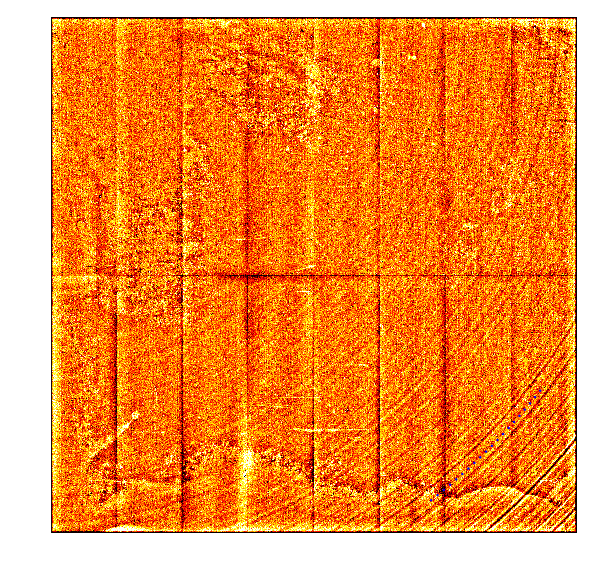

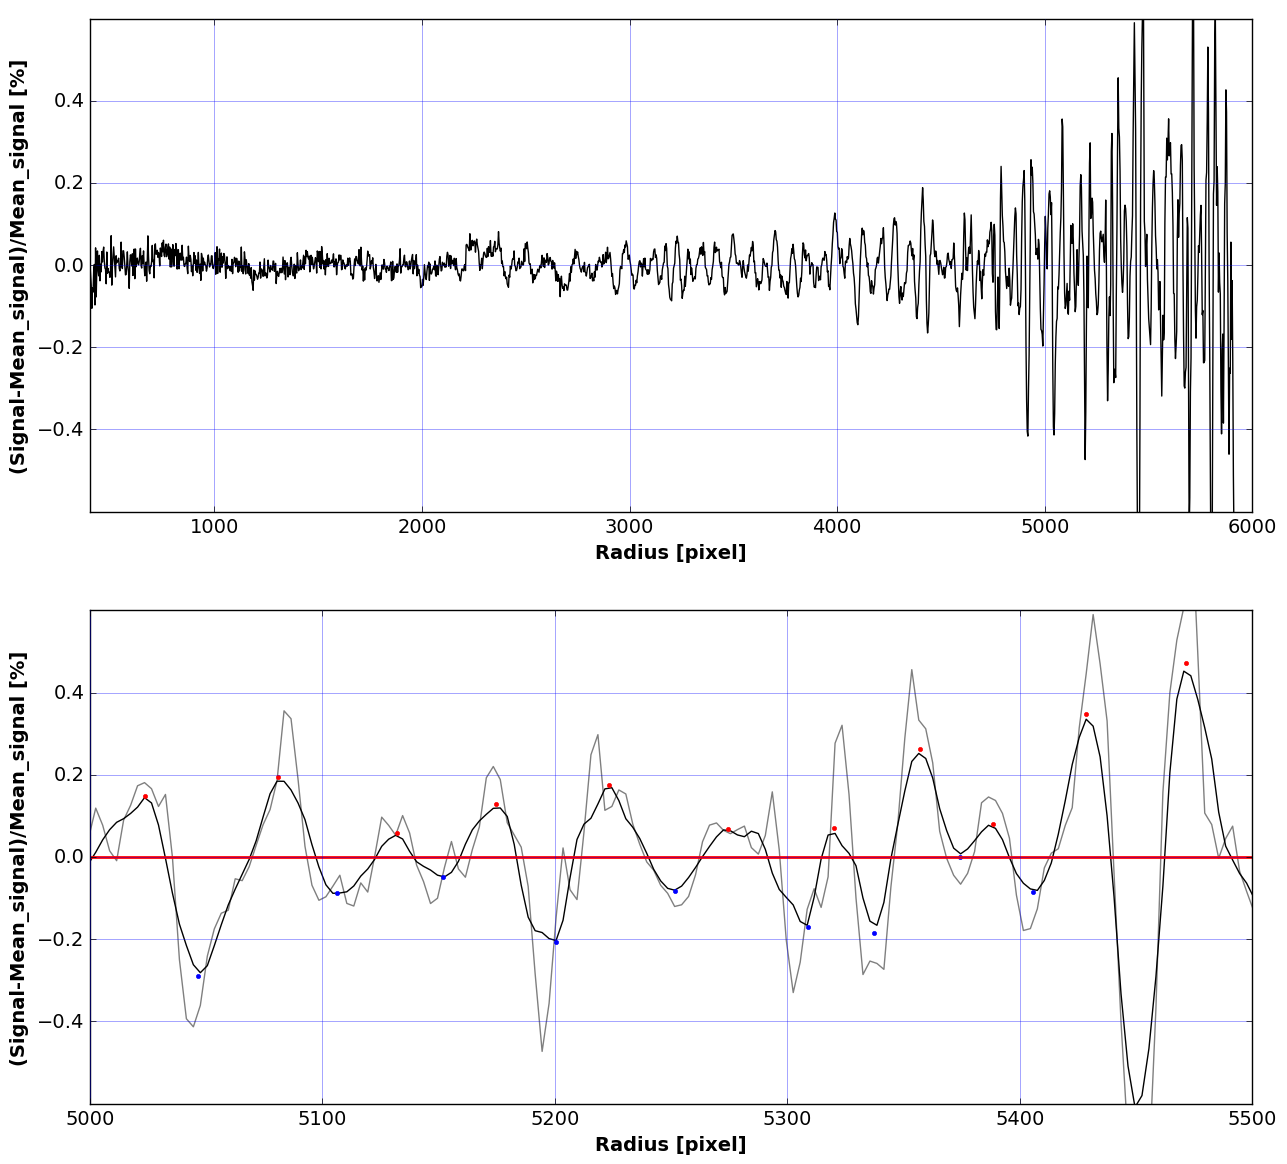

/Users/HyeYunPark/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:192: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


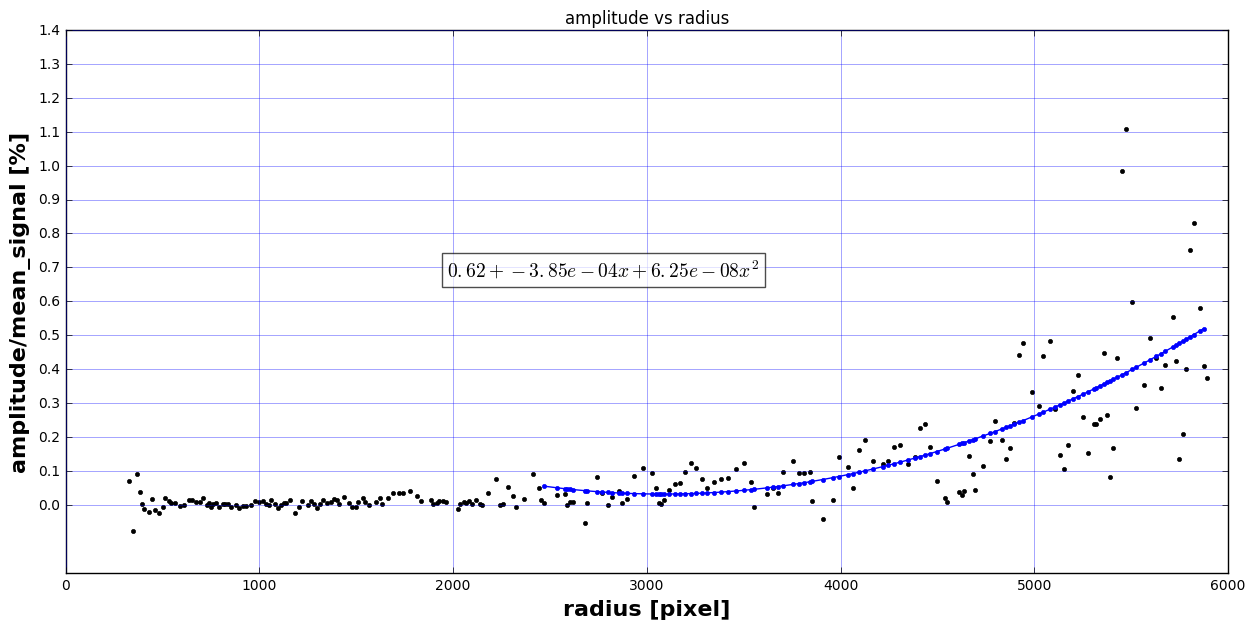

In [1916]:
dir=os.environ['ITL_DATA']+'assembled/'
filenames=listdir(dir)
for name in filenames:
    filename=dir+name
    nn=name[11:14]
    nn='017'
    dien=4
    if 'ITL-3800C-%s_sflat'%nn in filename:
        print name[11:14]
        hdul = fits.open(filename)
        header=hdul[0].header
        #print header.keys
        if 'E2V' in filename:
            if nn in ['349','297','305','293','258','129','185','269','229','217','153','179','134','114','195']:#'195'
                dien=1
            else:
                if nn in ['322','140','319','175','260','222','167']:#'195'
                    dien=3
                else:
                    if nn in ['177','213']:
                        dien=4
                    else: 
                        dien=2
            maxx=4096
            maxy=4004
            idnumber='E2V-%.1fV-%s-die%i'%(-float(header['CCDBSS']),nn,dien)
        if 'ITL' in filename:
            maxx=4072
            maxy=4000
            idnumber='ITL-%.1fV-%s-die%i'%(-float(header['CCDBSS']),nn,dien)
        if dien==1:
            ml=((4319.02,-281.43),(0,maxy))
        if dien==2:
            ml=((-156.33,-281.43),(maxx,maxy))
        if dien==3:
            ml=((4322.13,4183.53),(0,0))
        if dien==4:
            ml=((-156.33,4180.27),(maxx,0))
        print 'bias voltage=',header['CCDBSS'],'wavelength=', header['MONOCH-WAVELENG']
        
        if not os.path.exists('/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/'%idnumber):
            os.makedirs('/Users/HyeYunPark/Desktop/VMShared/2016SEP/%s/'%idnumber)
        plot_itl(filename,
                label=None, w_label='%.0fnm'%header['MONOCH-WAVELENG'],measure_line=ml,rradius=5000,die=dien,
                 idnumber=idnumber)
             #label=None, w_label='950nm',measure_line=((4322.13,4183.53),(0,0)),rradius=4400,die=3,idnumber=idnumber)
             #label=None, w_label='770nm',measure_line=((4096+522.2,4004+628.2),(0,0)),rradius=4400,die=3,idnumber=idnumber)
#die1:(4319.02,-281.43),(0,4000)),rradius=4400,die=1///(4096+522.2,4004+628.2),(0,0)),rradius=4400,die=3
#die2:(-156.33,-281.43),(4072,4000)),rradius=4400,die=2///(4096+522.2, -628.2),(0,4004)),rradius=4400,die=1
#die3:(4322.13,4183.53),(0,0)),rradius=4400,die=3 ///(-522.2, -628.2),(4096,4004)), rradius=4400, die=2
#die4:(-156.33,4180.27),(4072,0)),rradius=4400,die=4///(-522.2, -628.2), (4096,0)),rradius=4400,die=4


In [1749]:
read_files=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/*-167*amps_675nm.txt")
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/ratio.txt",'w') as outfile: 
    for f in read_files:
        bias_v=float(f[-29:-27])
        print bias_v
        print f
        if bias_v==0.0:
            float_lst = [float(x) for x in getCol(f)[1]]
            amp=np.asanyarray(float_lst,float)
            amp_radius=np.asanyarray([float(x) for x in getCol(f)[0]],float)
            z=np.polyfit([k/2 for k in (amp_radius[-45:-1:2]+amp_radius[-46:-2:2])], 
                         [j/2 for j in (amp[-45:-1:2]+amp[-46:-2:2])], 2)
            p = np.poly1d(z)
            print p
            outfile.write('\n%.1f %.2f %.2e %.2e'%(bias_v, p[0],p[1],p[2]))
        else:
            ff="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/ratio_-0.0V.txt"
            float_lst = [float(x) for x in getCol(f)[1]]
            #float_lst[:]= [x for x in float_lst if x>=0.01]
            amp=np.asanyarray(float_lst,float)
            amp_radius=np.asanyarray([float(x) for x in getCol(f)[0]],float)
            z=np.polyfit([k/2 for k in (amp_radius[-45:-1:2]+amp_radius[-46:-2:2])], 
                         [j/2 for j in (amp[-45:-1:2]+amp[-46:-2:2])], 2)
            p = np.poly1d(z)
            p_0_0=np.asanyarray([float(x) for x in getCol(ff)[0]],float)[0]
            p_0_1=np.asanyarray([float(x) for x in getCol(ff)[1]],float)[0]
            p_0_2=np.asanyarray([float(x) for x in getCol(ff)[2]],float)[0]
            p[0]=p_0_0/p[0]
            p[1]=p_0_1/p[1]
            p[2]=p_0_2/p[2]
            outfile.write('\n%.1f %.2f %.2e %.2e'%(bias_v,p[0],p[1],p[2]))
outfile.close()
            

70.0
/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/E2V--70.0V-167-die3_amps_675nm.txt
30.0
/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/E2V--30.0V-167-die3_amps_675nm.txt
50.0
/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/E2V--50.0V-167-die3_amps_675nm.txt
-0.0
/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/E2V-0.0V-167-die3_amps_675nm.txt
           2
5.834e-08 x - 0.0004549 x + 0.8875


combine 13 sensors done
(array([129, 322, 258, 185, 334, 152, 319, 293, 297, 305, 311, 349, 140]), array(['50.', '50.', '50.', '50.', '50.', '50.', '50.', '50.', '50.',
       '50.', '50.', '50.', '50.'], 
      dtype='|S3'))


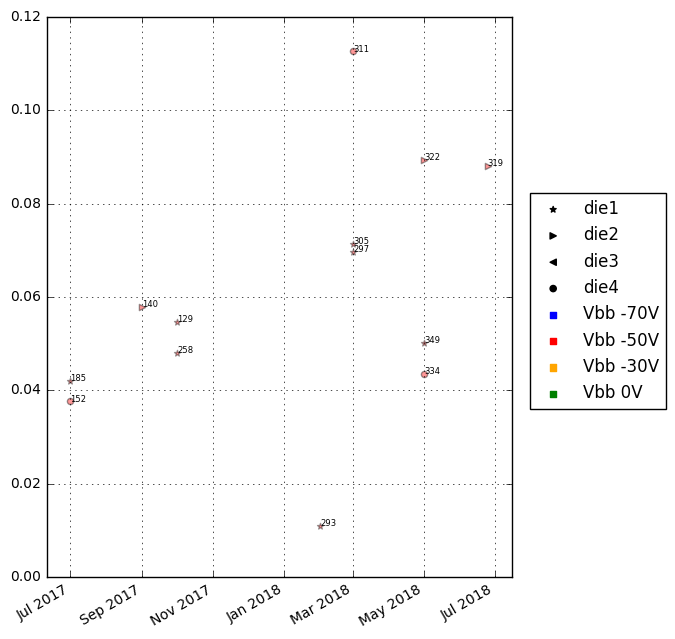

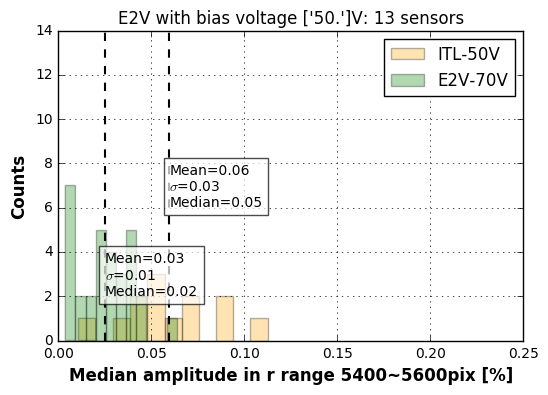

['0.0376' '50.' '152' '0.088' '50.' '319']


In [48]:
read_files=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/*amps_500nm.txt")
i=0
amp,amp_radius=[],[]
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_period.txt",'w') as outfile: 
    for f in read_files:
        if 'E2V--50' in f:
            i+=1
            float_lst = [float(x) for x in getCol(f)[1]]
            #float_lst[:]= [x for x in float_lst if x>=0.01]
            amp=np.asanyarray(float_lst,float)
            amp_radius=np.asanyarray([float(x) for x in getCol(f)[0]],float)
            z=np.polyfit([k/2 for k in (amp_radius[-45:-1:2]+amp_radius[-46:-2:2])], 
                         [j/2 for j in (amp[-45:-1:2]+amp[-46:-2:2])], 2)
            p = np.poly1d(z)
            max_amp=np.median(p([kk for kk in amp_radius if kk>=5400 and kk<=5600]))#5400~5600
            #print [kk for kk in amp_radius if kk>=5400 and kk<=5600]
            if f[54:57]=='ITL':
                temp_bias=f[-28:-25]
            else:
                temp_bias=f[-29:-26]
            outfile.write('%.4f %i %i %s %s \n'%(max_amp,int(f[-23:-20]), int(f[-16]), temp_bias,f[54:57]))
            
print "combine %i sensors done"%(i)

hist_file="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_period.txt"

max_amp = np.asanyarray(getCol(hist_file)[0],float)
id_number=np.asanyarray(getCol(hist_file)[1],int)
die_number=np.asanyarray(getCol(hist_file)[2],int)
bias=np.asanyarray(getCol(hist_file)[3],str)
print (id_number,bias)
vendor=np.asanyarray(getCol(hist_file)[4],str)
colors,die1_amp,die2_amp,die3_amp,die4_amp,shapes=[],[],[],[],[],[]
i=0
amp_0,amp_30,amp_50,amp_70=[],[],[],[]
id_0,id_30,id_50,id_70=[],[],[],[]

for kk, b in enumerate(bias):
    if b=='-0.':
        amp_0=np.append(amp_0,max_amp[kk])
        id_0=np.append(id_0,id_number[kk])
        colors=np.append(colors,'green')       
        i+=1
    if b=='70.':
        amp_70=np.append(amp_70,max_amp[kk])
        id_70=np.append(id_70,id_number[kk])
        colors=np.append(colors,'blue')
        i+=1
    if b=='50.':
        amp_50=np.append(amp_50,max_amp[kk])
        max_amp[kk]=max_amp[kk]#/1.34
        id_50=np.append(id_50,id_number[kk])
        colors=np.append(colors,'red')
        i+=1
    if b=='30.' or b=='35.':
        amp_30=np.append(amp_30,max_amp[kk])
        max_amp[kk]=max_amp[kk]##*0.05/0.19
        id_30=np.append(id_30,id_number[kk])
        colors=np.append(colors,'orange')
        i+=1
        

if vendor[0]=='RTM':  
    import operator
    L0 = sorted(zip(id_0,amp_0), key=operator.itemgetter(0))
    id_0, amp_0 = zip(*L0)
    L30 = sorted(zip(id_30,amp_30), key=operator.itemgetter(0))
    id_30, amp_30 = zip(*L30)
    L50 = sorted(zip(id_50,amp_50), key=operator.itemgetter(0))
    id_50, amp_50 = zip(*L50)
    L70 = sorted(zip(id_70,amp_70), key=operator.itemgetter(0))
    id_70, amp_70 = zip(*L70)
    #print amp_0

    ratio_0=np.array(amp_0)#/np.array(amp_0)
    ratio_30=np.array(amp_30)#/np.array(amp_0)
    ratio_50=np.array(amp_50)#/np.array(amp_0)
    ratio_70=np.array(amp_70)#/np.array(amp_0)

    fig, ax = plt.subplots()
    ax.scatter(id_0,ratio_0, c='black', label="0V ratio to 0V=%.2f std=%.2f"%(np.mean(ratio_0),np.std(ratio_0)))
    ax.scatter(id_30,ratio_30, c='orange', label="30V ratio to 0V=%.2f std=%.2f"%(np.mean(ratio_30),np.std(ratio_30)))
    ax.scatter(id_50,ratio_50, c='red',label="50V ratio to 0V=%.2f std=%.2f"%(np.mean(ratio_50),np.std(ratio_50)))
    ax.scatter(id_70,ratio_70, c='blue',label="70V ratio to 0V=%.2f std=%.2f"%(np.mean(ratio_70),np.std(ratio_70)))
    plt.axhline(np.mean(ratio_0),color='green',linestyle='dashed',linewidth=1.5)
    plt.axhline(np.mean(ratio_30), color='orange', linestyle='dashed', linewidth=1.5)
    plt.axhline(np.mean(ratio_50), color='red', linestyle='dashed', linewidth=1.5)
    plt.axhline(np.mean(ratio_70), color='blue', linestyle='dashed', linewidth=1.5)
    ax.set_xticks(id_30)
    ax.set_xlabel('ID number')
    ax.legend(scatterpoints=1)
    
i=0
for die in die_number:
    if die==1:
        shapes=np.append(shapes,u"*")
        die1_amp=np.append(die1_amp,max_amp[i])
        i+=1
    if die==2:
        shapes=np.append(shapes,u"o")
        die2_amp=np.append(die2_amp,max_amp[i])
        i+=1
    if die==3:
        shapes=np.append(shapes,u">")
        die3_amp=np.append(die3_amp, max_amp[i])
        i+=1
    if die==4:
        shapes=np.append(shapes,u'<')
        die4_amp=np.append(die4_amp, max_amp[i])
        i+=1


amp_e2v,amp_itl=[],[]
for k,v in enumerate(vendor):
    if v=='E2V':
        v30=30
        amp_e2v=np.append(amp_e2v,max_amp[k])
    if v=='ITL':
        v30=35
        amp_itl=np.append(amp_itl,max_amp[k])

#print max_amp
#print np.mean(max_amp)
#print id_number

x_decor = [(idx, val) for idx, val in enumerate(max_amp)]
x_decor.sort(key=lambda itm: itm[1])
x_idxs = [idx for idx, val in x_decor]
y_vals = [id_number[idx] for idx in x_idxs]
x_vals=[max_amp[idx] for idx in x_idxs]
#print x_vals, y_vals

ym=['']*(len(id_number))
comp_5070=[]
kk=0
for kk, n in enumerate(id_number):
    if vendor[kk]=='E2V':
        if n in [319]:
            ym[kk]=datetime.date(2018,6,25)
            comp_5070=np.append(comp_5070,(max_amp[kk],bias[kk],n))
        if n in [349,334,322]:
            ym[kk]=datetime.date(2018,5,1)
        if n in [297, 311, 305]:
            ym[kk]=datetime.date(2018,3,1)
        if n in [293]:
            ym[kk]=datetime.date(2018,2,1)
        if n in [258, 129]:
            ym[kk]=datetime.date(2017,10,1)
        if n in [140]:
            ym[kk]=datetime.date(2017,9,1)
        if n in [152, 228, 185,251]:
            if n==152:
                comp_5070=np.append(comp_5070,(max_amp[kk],bias[kk],n))
            ym[kk]=datetime.date(2017,7,1)
        if n in [281]:
            ym[kk]=datetime.date(2017,6,1)
        if n in [265, 266,269,267]:
            ym[kk]=datetime.date(2017,5,1)
        if n in [229, 194,260,195,160,217,153,239]:
            ym[kk]=datetime.date(2017,3,1)
        if n in [163,177,216,131,136,137,222,175,213,201,167]:
            ym[kk]=datetime.date(2016,12,1)
        if n in [165,179,134,132,154,177]:
            ym[kk]=datetime.date(2016,11,1)
        if n in [107,114]:
            ym[kk]=datetime.date(2016,6,1)
        if n in [88]:
            ym[kk]=datetime.date(2015,12,1)
        if n not in [88,107,114,165,179,134,132,154,163,177,216,131,136,137,229, 194,260,195,160,217,153,239,265, 
                        266,269,267,281,152, 228, 185,251,140,258, 129,293,297,311, 305,349,334,322,319,222,175,213,201,167,
                    177]:
            print "you need to put date received for %s" %n
    if vendor[kk]=='ITL':
        if n in [98,91,97]:
            ym[kk]=datetime.date(2016,5,9)
        if n in [17]:
            ym[kk]=datetime.date(2016,6,20)
        if n in [146,22,145,102]:
            ym[kk]=datetime.date(2016,7,15)
        if n in [34,61]:
            ym[kk]=datetime.date(2016,9,12)
        if n in [92,95]:
            ym[kk]=datetime.date(2017,3,15)
        if n in [83,136,228,235,164]:
            ym[kk]=datetime.date(2017,7,15)
        if n in [229,231,212,269,109,251,282,214,244,243,62,207]:
            ym[kk]=datetime.date(2017,9,15)
        if n in [206,283,326]:
            ym[kk]=datetime.date(2017,12,1)
        if n in [350,368]:
            ym[kk]=datetime.date(2018,1,15)
        if n in [307]:
            ym[kk]=datetime.date(2018,2,19)
        if n in [377,328,342,400,406]:
            ym[kk]=datetime.date(2018,4,9)
        if n in [340,345,451,210,467,461,454,76]:
            ym[kk]=datetime.date(2018,5,16)
        if n in [88,110,509,140]:
            ym[kk]=datetime.date(2018,6,22)
        if n not in [88,110,509,340,345,451,210,467,461,454,76,377,328,342,400,406,307,350,368,206,283,326,
                    229,231,212,269,109,251,282,214,244,243,62,207,83,136,228,235,164,92,95,34,61,146,22,145,17,
                     98,97,91,140,102]:
            print "you need to put date received for %s" %n
        
j=0
fig, ax = plt.subplots(figsize=[6,8])
for _s, c, _x, _y in zip(shapes, colors, ym, max_amp):
    ax.scatter(_x, _y, marker=_s, c=c, alpha=0.4)
#ax.scatter(ym, max_amp,alpha=0.5, marker=np.asanyarray(shapes,str),c=colors)
for j, txt in enumerate(id_number):
    ax.text(ym[j],max_amp[j],txt, size=6)
ax.autoscale_view()
#ax.xaxis.grid(False, 'major')
#ax.xaxis.grid(True, 'minor')
ax.grid()
ax.scatter([],[],marker='*', color='black', label='die1')
ax.scatter([],[],marker='>', color='black', label='die2')
ax.scatter([],[],marker='<', color='black', label='die3')
ax.scatter([],[],marker='o', color='black', label='die4')
ax.scatter([],[],marker='s', color='blue', label='Vbb -70V')
ax.scatter([],[],marker='s', color='red', label='Vbb -50V')
ax.scatter([],[],marker='s',color='orange',label='Vbb -%iV'%v30)
ax.scatter([],[],marker='s', color='green', label='Vbb 0V')
ax.legend(scatterpoints=1, bbox_to_anchor=(1.35, 0.7))
#ax.set_ylim(0,0.15)
fig.autofmt_xdate()


figg, axx = plt.subplots()
axx.hist(max_amp,normed=None,color='orange',alpha=0.3,bins=11, label="ITL-50V")#i/2
#temp_amp=max_amp
axx.hist(temp_amp,normed=None, color='green', alpha=0.3, bins=11,label="E2V-70V")
#axx.hist(amp_0,normed=None, color='green',alpha=0.2,bins=0.01*np.arange(0,24),label="0V")
#axx.hist(amp_30,normed=None, color='orange',alpha=0.2,bins=0.01*np.arange(0,24),label="%sV"%v30)
#axx.hist(amp_50,normed=None, color='red',alpha=0.2,bins=0.01*np.arange(0,24),label="50V")
#axx.hist(amp_70,normed=None, color='blue',alpha=0.2,bins=0.01*np.arange(0,24),label="70V")
#axx.hist(die2_amp,normed=None,facecolor='blue',alpha=0.5,bins=np.arange(0,0.12,0.005),label='die2')
#axx.hist(die4_amp,normed=None,facecolor='green',alpha=0.5,bins=np.arange(0,0.12,0.005),label='die4')
plt.xlabel('Median amplitude in r range 5400~5600pix [%]', fontweight='bold', fontsize=12)
plt.ylabel('Counts', fontweight='bold', fontsize=12)
#plt.tick_params(axis='both', which='major', labelsize=14)
#plt.title('mean amplutdes over points [-20,-10] of %i sensors'%(len(read_files)))
plt.axis([0,0.25, 0,14])
plt.axvline(max_amp.mean(), color='black', linestyle='dashed', linewidth=1.5)
plt.axvline(temp_amp.mean(), color='black', linestyle='dashed', linewidth=1.5)
#plt.axvline(np.mean(amp_0), color='green', linestyle='dashed', linewidth=1.5)
#plt.axvline(np.mean(amp_30), color='orange', linestyle='dashed', linewidth=1.5)
#plt.axvline(np.mean(amp_50), color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(np.mean(amp_70), color='blue', linestyle='dashed', linewidth=1.5)
#plt.axvline(die1_amp.mean(), color='r', linestyle='dashed', linewidth=1.5)
#plt.axvline(die2_amp.mean(), color='b', linestyle='dashed', linewidth=1.5)
#plt.axvline(die4_amp.mean(), color='g', linestyle='dashed', linewidth=1.5)
#plt.legend(loc='upper right')
#textstr='           0V 30V 50V 70V\nMean=%.2f %.2f %.2f %.2f\n      $\sigma$=%.2f %.2f %.2f %.2f'%(np.mean(amp_0),np.mean(amp_30),
#                                                                                  np.mean(amp_50),np.mean(amp_70),
#                                                                                  np.std(amp_0),np.std(amp_30),
#                                                                                 np.std(amp_50),np.std(amp_70))
textstr='Mean=%.2f\n$\sigma$=%.2f\nMedian=%.2f'%(np.mean(max_amp),np.std(max_amp),np.median(max_amp))
temp_str='Mean=%.2f\n$\sigma$=%.2f\nMedian=%.2f'%(np.mean(temp_amp),np.std(temp_amp),np.median(temp_amp))
#textstr='Mean_35V=%.2f\n$\sigma$=%.2f\nMedian=%.2f'%(np.mean(amp_30),np.std(amp_30),np.median(amp_30))
#textstr2='Mean_50V=%.2f\n$\sigma$=%.2f\nMedian=%.2f'%(np.mean(amp_50),np.std(amp_50),np.median(amp_50))
#textstr='ITL mean=%.2f\ne2v mean=%.2f'%(amp_itl.mean(),amp_e2v.mean())
props=dict(facecolor='white',alpha=0.7)

plt.text(np.mean(max_amp),8,textstr,fontsize=10,verticalalignment='top',bbox=props)
plt.text(np.mean(temp_amp),4,temp_str,fontsize=10,verticalalignment='top',bbox=props)
#plt.text(np.mean(amp_30),4,textstr,fontsize=10,verticalalignment='top',bbox=props)
#plt.text(np.mean(amp_50),4,textstr2,fontsize=10,verticalalignment='top',bbox=props)

#plt.scatter(same_waf_1_mean, np.ones(len(same_waf_1_mean)),alpha=1, color=same_waf_1_color, marker='x',zorder=1)
#major_ticks=np.arange(0,0.12,0.01)
#axx.set_xticks(major_ticks)
axx_set_xlim=(0,0.4)
#axx.set_ylim(0,5)
a=list(set(bias))
axx.set_title("%s with bias voltage %sV: %i sensors"%(vendor[0],a,i))
#axx.set_title("E2V and ITL with proposed back bias voltage")
plt.grid(True)
plt.legend()
plt.show()

print (comp_5070)


[ 0.     0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125
  1.25   1.375  1.5    1.625  1.75   1.875  0.2    0.3    0.7    0.8    1.2
  1.3    1.7    1.8  ]


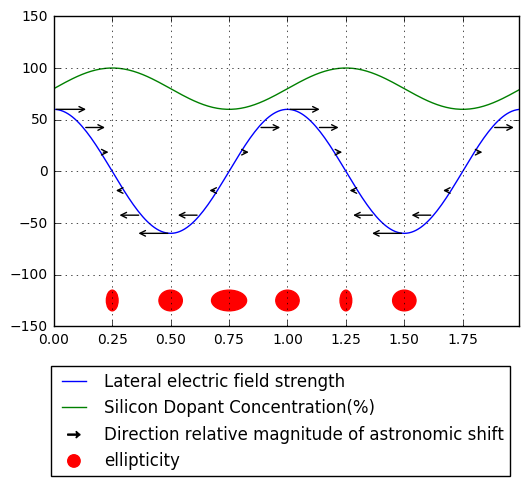

In [1555]:
x=np.arange(0,2,0.01)
y=60*cos(2*np.pi*x)
y2=80+20*sin(2*np.pi*x)

a_x=np.asanyarray(np.append(np.arange(0,2,0.25/2),[0.2,0.3,0.7,0.8,1.2,1.3,1.7,1.8]),float)
a_y=60*np.cos(2*np.pi*a_x)
print a_x
length_x=a_y/400

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches


e_x=np.asanyarray(np.arange(0.25,1.75, 0.25),float)
e_width=0.1-0.05*np.sin(2*np.pi*e_x)
ells = [Ellipse((e_x[j], -125), e_width[j], 20, 0, color='red') for j in np.arange(len(e_x))]

fig, ax=plt.subplots()
h1=ax.plot(x,y,label='Lateral electric field strength')
h2=ax.plot(x,y2,label='Silicon Dopant Concentration(%)')
ax.grid()
major_ticks=np.arange(0,2,0.25)
ax.set_xticks(major_ticks)
ax.set_ylim(-150,150)


for i in range(len(a_x)):
    ax.annotate("", xy=(a_x[i]+length_x[i], a_y[i]), xytext=(a_x[i], a_y[i]), 
                arrowprops=dict(arrowstyle="->"))
for e in ells:
    e.set_clip_box(ax.bbox)
    e.set_alpha(1)
    e.set_label('ellipticity')
    ax.add_artist(e)
arrow=u'$\u2192$'
ax.scatter([],[],marker=arrow, color='black', label='Direction relative magnitude of astronomic shift')
ax.scatter([],[],marker='o', color='r', label='ellipticity')

ax.legend(markerscale=2,scatterpoints=1,bbox_to_anchor=(1, -0.1))

In [1883]:
test_list=[1,2,3,4,5,6,1,2,3,3]
a=set(test_list)
print a

set([1, 2, 3, 4, 5, 6])


In [ ]:
filename='ITL-3800C-107_lambda_flat_0770_045_20160920005254_assembled.fits'
num_sigmas_clip=4
smoothing=250
data = fitsio.read(os.path.join(os.environ['ITL_DATA'], filename))
levels, mask = zero_by_region(data, (2000, 509), num_sigmas_clip, smoothing)
level = np.median(levels)
data, mask = downsample(data, mask, 4)
lo, hi = np.percentile(data[mask].ravel(), (0.5 * 10, 100 - 0.5 * 10))
#x,y,z=[],[],[]
#for i in range(0,1018,4):
#    for j in range(0,1000,4):
#        x=np.append(x,i)
#        y=np.append(y,j)
#        z=np.append(z,data[j,i])

x,y=np.meshgrid(np.linspace(0,1018,1018,endpoint=False),np.linspace(0,1000,1000,endpoint=False))
fig = plt.figure()
ax = fig.add_subplot(122,projection='3d')
ax1 = fig.add_subplot(121)
ax1.imshow(data, cmap='hot')
surf = ax.contourf(x,y,data, rstride=1, cstride=1, cmap='hot',linewidth=0,antialiased=False)
#ax.set_zlim(-0.002,0.002)

#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename_017='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amplitude.txt'
filename_017_line_970='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amplitude_970_line.txt'
filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/022_amplitude.txt'
filename_145='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/145_amplitude.txt'
filename_107='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/107_amplitude.txt'


radius_017=np.asanyarray(getCol(filename_017)[0],int)
amp_017=np.asanyarray(getCol(filename_017)[1], float)
max_amp_017=np.maximum(amp_017)
radius_017_line_970=np.asanyarray(getCol(filename_017_line_970)[0],int)
amp_017_line_970=np.asanyarray(getCol(filename_017_line_970)[1], float)
radius_022=np.asanyarray(getCol(filename_022)[0],int)
amp_022=np.asanyarray(getCol(filename_022)[1], float)
max_amp_022=np.maximum(amp_022)
radius_145=np.asanyarray(getCol(filename_145)[0],int)
amp_145=np.asanyarray(getCol(filename_145)[1], float)
max_amp_145=np.maximum(amp_145)
radius_107=np.asanyarray(getCol(filename_107)[0],int)
amp_107=np.asanyarray(getCol(filename_107)[1], float)
max_amp_107=np.maximum(amp_107)

fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
ax.plot(radius_017,amp_017,'k.-', color='red', label='ITL-017')
ax.plot(radius_017_line_970,amp_017_line_970,'k.--', color='red', label='ITL-017')
ax.plot(radius_022,amp_022,'k.-', color='black', label='ITL-022')
ax.plot(radius_145,amp_145,'k.-', color='green', label='ITL-145')
ax.plot(radius_107,amp_107,'k.-', color='blue', label='ITL-107')
ax.grid(c='b', ls='-', alpha=0.5)
#ax.set_xlim(4000,5000)
#ax.set_yticks(np.arange(0,1.5,0.1)), dr, xgrid))
ax.set_xlabel('Radius [pixel]',fontweight='bold', fontsize=16)
ax.set_ylabel('Amplitude/Mean_signal [%]',fontweight='bold', fontsize=16)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes.png')
plt.show()

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/RTM1_061_p_in_range_770nm.txt'
filename_2='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/RTM1_061_normal_p_in_range_770nm.txt'

radius=np.asanyarray(getCol(filename)[0],int)
amp=np.asanyarray(getCol(filename)[1], float)*100
r_017=np.asanyarray(getCol(filename_2)[0],int)
a_017=np.asanyarray(getCol(filename_2)[1],float)*100

peakind = signal.find_peaks_cwt(amp, np.arange(1,4))#, noise_perc=21)
min_peak=signal.find_peaks_cwt(-amp, np.arange(1,4))
#freq=np.arange(len(amp))*len(amp)/len(amp)
#freq=freq[range(len(amp)/2)]
freq=np.fft.fftfreq(len(amp[100:1900]))
freq=freq[range(len(amp[100:1900])/2)]
Y=np.fft.fft(amp[100:1900])/len(amp[100:1900])
Y=Y[range(len(amp[100:1900])/2)]

fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
#ax.plot(freq,abs(Y),'k.--',color='blue')
ax.plot(radius,amp,'k.-', color='black', label='high_low')
ax.plot(radius[peakind], amp[peakind], 'k.', color='red', markersize=15)
ax.plot(radius[min_peak], amp[min_peak], 'k.', color='blue', markersize=15)
#ax.plot(r_017,a_017,'k.--',color='black',label='normal')
ax.grid(c='b', ls='-', alpha=0.5)
#ax.set_xlim(3000,5800)
ax.set_ylim(-0.6,0.4)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
ax.set_xlabel('Radius [pixel]',fontweight='bold',fontsize=16)
ax.set_ylabel('Profile [%]',fontweight='bold',fontsize=16)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/high_low_both_cut.png')
plt.show()


In [ ]:
from scipy import signal
xs = np.arange(0, 4, 0.05)
data = np.sin(xs*2*np.pi)
peakind = signal.find_peaks_cwt(data, np.arange(2,10))
min_peak=signal.find_peaks_cwt(-data,np.arange(2,10))
print peakind, xs[peakind], data[peakind]
fig=plt.figure(figsize=[8,3])
ax=fig.add_subplot(111)
ax.set_ylim(-1.1,1.1)
ax.plot(xs,data,'k.-', color='black', label='example')
ax.plot(xs[peakind],data[peakind], 'k.', color='red', markersize=15)
ax.plot(xs[min_peak],data[min_peak], 'k.', color='blue', markersize=15)

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename_017='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_970nm.txt'
#filename_017='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_770nm.txt'
filename_017_320='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_320nm.txt'
filename_017_line_970='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_400nm.txt'
filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_540nm.txt'
#filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/022_p_in_range_770nm.txt'
filename_145='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_770nm.txt'
filename_107='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_850nm.txt'


radius_017=np.asanyarray(getCol(filename_017)[0],int)
amp_017=np.asanyarray(getCol(filename_017)[1], float)*100
radius_017_320=np.asanyarray(getCol(filename_017_320)[0],int)
amp_017_320=np.asanyarray(getCol(filename_017_320)[1], float)*100
radius_017_970_line=np.asanyarray(getCol(filename_017_line_970)[0],int)
amp_017_970_line=np.asanyarray(getCol(filename_017_line_970)[1], float)*100
radius_022=np.asanyarray(getCol(filename_022)[0],int)#-np.ones(len(np.asanyarray(getCol(filename_022)[0],int)))*162
amp_022=np.asanyarray(getCol(filename_022)[1], float)*100
radius_145=np.asanyarray(getCol(filename_145)[0],int)
amp_145=np.asanyarray(getCol(filename_145)[1], float)*100
radius_107=np.asanyarray(getCol(filename_107)[0],int)
amp_107=np.asanyarray(getCol(filename_107)[1], float)*100

fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
ax.plot(radius_017,amp_017,'k.--', color='red', label='ITL-017')
#ax.plot(radius_017_970_line,amp_017_970_line,'k.--', color='red', label='ITL-017')
ax.plot(radius_017_320,amp_017_320,'k.-', color='orange', label='ITL-017-320nm')
ax.plot(radius_017_970_line,amp_017_970_line,'k.-', color='green', label='ITL-017')
ax.plot(radius_022,amp_022,'k.-', color='cyan', label='ITL-022')
ax.plot(radius_145,amp_145,'k.-', color='blue', label='ITL-145')
ax.plot(radius_107,amp_107,'k.-', color='magenta', label='ITL-107')
ax.grid(c='b', ls='-', alpha=0.5)
ax.set_xlim(4800,5300)
ax.set_ylim(-0.6,0.4)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
ax.set_xlabel('Radius [pixel]',fontweight='bold',fontsize=16)
ax.set_ylabel('Profile [%]',fontweight='bold',fontsize=16)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/compare_017_022.png')
plt.show()

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename_itl_017='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_770nm.txt'
filename_e2v_163='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-163_p_in_range_770nm.txt'
filename_e2v_177='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-177_p_in_range_770nm.txt'
filename_e2v_216='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-216_p_in_range_770nm.txt'
filename_e2v_239='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-239_p_in_range_770nm.txt'
filename_e2v_131='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-131_p_in_range_770nm.txt'
filename_e2v_136='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-136_p_in_range_770nm.txt'
filename_e2v_137='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-137_p_in_range_770nm.txt'
filename_e2v_153='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-153_p_in_range_770nm.txt'
filename_e2v_165='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-165_p_in_range_770nm.txt'
filename_e2v_195='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-195_p_in_range_770nm.txt'

radius_itl_017=np.asanyarray(getCol(filename_itl_017)[0],int)
amp_itl_017=np.asanyarray(getCol(filename_itl_017)[1], float)*100
radius_e2v_163=np.asanyarray(getCol(filename_e2v_163)[0],int)
amp_e2v_163=np.asanyarray(getCol(filename_e2v_163)[1], float)*100
radius_e2v_177=np.asanyarray(getCol(filename_e2v_177)[0],int)
amp_e2v_177=np.asanyarray(getCol(filename_e2v_177)[1], float)*100
radius_e2v_216=np.asanyarray(getCol(filename_e2v_216)[0],int)
amp_e2v_216=np.asanyarray(getCol(filename_e2v_216)[1], float)*100
radius_e2v_239=np.asanyarray(getCol(filename_e2v_239)[0],int)
amp_e2v_239=np.asanyarray(getCol(filename_e2v_239)[1], float)*100
radius_e2v_131=np.asanyarray(getCol(filename_e2v_131)[0],int)
amp_e2v_131=np.asanyarray(getCol(filename_e2v_131)[1], float)*100
radius_e2v_136=np.asanyarray(getCol(filename_e2v_136)[0],int)
amp_e2v_136=np.asanyarray(getCol(filename_e2v_136)[1], float)*100
radius_e2v_137=np.asanyarray(getCol(filename_e2v_137)[0],int)
amp_e2v_137=np.asanyarray(getCol(filename_e2v_137)[1], float)*100
radius_e2v_165=np.asanyarray(getCol(filename_e2v_165)[0],int)
amp_e2v_165=np.asanyarray(getCol(filename_e2v_165)[1], float)*100
radius_e2v_195=np.asanyarray(getCol(filename_e2v_195)[0],int)
amp_e2v_195=np.asanyarray(getCol(filename_e2v_195)[1], float)*100


fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
ax.plot(radius_itl_017,amp_itl_017,'k.-', color='blue', label='ITL-017, 770nm')
ax.plot(radius_e2v_163,amp_e2v_163,'k.-', color='black', label='e2v-163, 770nm')
ax.plot(radius_e2v_177,amp_e2v_177,'k.-', color='black', label='e2v-177, 770nm')
ax.plot(radius_e2v_216,amp_e2v_216,'k.-', color='red', label='e2v-216, 770nm')
ax.plot(radius_e2v_239,amp_e2v_239,'k.-', color='black', label='e2v-239, 770nm')
ax.plot(radius_e2v_131,amp_e2v_239,'k.-', color='black', label='e2v-131, 770nm')
ax.plot(radius_e2v_136,amp_e2v_239,'k.-', color='black', label='e2v-136, 770nm')
ax.plot(radius_e2v_137,amp_e2v_239,'k.-', color='black', label='e2v-137, 770nm')
ax.plot(radius_e2v_165,amp_e2v_239,'k.-', color='black', label='e2v-165, 770nm')
ax.plot(radius_e2v_195,amp_e2v_239,'k.-', color='black', label='e2v-195, 770nm')

ax.grid(c='b', ls='-', alpha=0.5)
ax.set_xlim(5000,5800)
ax.set_ylim(-0.6,0.4)
#ax.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
ax.set_xlabel('radius [pixel]',fontweight='bold')
ax.set_ylabel('profile [%]',fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/compare_ITL_E2V.png')
plt.show()

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename_017='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_770nm.txt'
#filename_017='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_770nm.txt'
filename_017_320='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_320nm.txt'
filename_017_line_970='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_p_in_range_400nm.txt'
filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/022_p_in_range_770nm.txt'
#filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/022_p_in_range_770nm.txt'
filename_145='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/145_p_in_range_770nm.txt'
filename_107='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/107_p_in_range_770nm.txt'


radius_017=np.asanyarray(getCol(filename_017)[0],int)#+np.ones(len(np.asanyarray(getCol(filename_017)[0],int)))*10
amp_017=np.asanyarray(getCol(filename_017)[1], float)*100
radius_017_320=np.asanyarray(getCol(filename_017_320)[0],int)
amp_017_320=np.asanyarray(getCol(filename_017_320)[1], float)*100
radius_017_970_line=np.asanyarray(getCol(filename_017_line_970)[0],int)
amp_017_970_line=np.asanyarray(getCol(filename_017_line_970)[1], float)*100
radius_022=np.asanyarray(getCol(filename_022)[0],int)#-np.ones(len(np.asanyarray(getCol(filename_022)[0],int)))*150
amp_022=np.asanyarray(getCol(filename_022)[1], float)*100
radius_145=np.asanyarray(getCol(filename_145)[0],int)#-np.ones(len(np.asanyarray(getCol(filename_022)[0],int)))*20
amp_145=np.asanyarray(getCol(filename_145)[1], float)*100
radius_107=np.asanyarray(getCol(filename_107)[0],int)
amp_107=np.asanyarray(getCol(filename_107)[1], float)*100

fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
ax.plot(radius_145,amp_145,'k.-', color='red', label='ITL-145')
ax.plot(radius_107,amp_107,'k.-',color='blue',label='ITL-107')
ax.grid(c='b', ls='-', alpha=0.5)
ax.set_xlim(4500,5300)
ax.set_ylim(-0.5,.5)

#ax.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
ax.set_xlabel('Radius [pixel]',fontweight='bold', fontsize=16)
ax.set_ylabel('Signal/Mean signal [%]',fontweight='bold', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/compare_two.png')
plt.show()

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename_017_970='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_770nm.txt'
filename_017_970_line='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-163_amps_770nm.txt'
filename_017_320='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-177_amps_770nm.txt'
filename_017_400='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-216_amps_770nm.txt'
filename_017_540='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v-239_amps_770nm.txt'
#filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/022_p_in_range_770nm.txt'
#filename_017_770='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_770nm.txt'
#filename_017_850='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_850nm.txt'


radius_017_970=np.asanyarray(getCol(filename_017_970)[0],int)
amp_017_970=np.asanyarray(getCol(filename_017_970)[1], float)
radius_017_line=np.asanyarray(getCol(filename_017_970_line)[0],int)
amp_017_line=np.asanyarray(getCol(filename_017_970_line)[1], float)
radius_017_320=np.asanyarray(getCol(filename_017_320)[0],int)
amp_017_320=np.asanyarray(getCol(filename_017_320)[1], float)
radius_017_400=np.asanyarray(getCol(filename_017_400)[0],int)
amp_017_400=np.asanyarray(getCol(filename_017_400)[1], float)
radius_017_540=np.asanyarray(getCol(filename_017_540)[0],int)#-np.ones(len(np.asanyarray(getCol(filename_022)[0],int)))*162
amp_017_540=np.asanyarray(getCol(filename_017_540)[1], float)
#radius_017_770=np.asanyarray(getCol(filename_017_770)[0],int)
#amp_017_770=np.asanyarray(getCol(filename_017_770)[1], float)
#radius_017_850=np.asanyarray(getCol(filename_017_850)[0],int)
#amp_017_850=np.asanyarray(getCol(filename_017_850)[1], float)

#print len(amp_017_320),len(amp_017_400),len(amp_017_540),len(amp_017_770),len(amp_017_850),len(amp_017_970)
r_min,r_max=3500,5500
binnumber=10
p_320,edges=np.histogram(radius_017_320, bins=binnumber, range=(r_min,r_max),weights=amp_017_320)
c_320,edges=np.histogram(radius_017_320, bins=binnumber, range=(r_min,r_max))
p_320/=c_320
p_320[np.isnan(p_320)]=0
p_400,edges=np.histogram(radius_017_400, bins=binnumber, range=(r_min,r_max),weights=amp_017_400)
c_400,edges=np.histogram(radius_017_400, bins=binnumber, range=(r_min,r_max))
p_400/=c_400
p_400[np.isnan(p_400)]=0
p_540,edges=np.histogram(radius_017_540, bins=binnumber, range=(r_min,r_max),weights=amp_017_540)
c_540,edges=np.histogram(radius_017_540, bins=binnumber, range=(r_min,r_max))
p_540/=c_540
p_540[np.isnan(p_540)]=0
#p_770,edges=np.histogram(radius_017_770, bins=binnumber, range=(r_min,r_max),weights=amp_017_770)
#c_770,edges=np.histogram(radius_017_770, bins=binnumber, range=(r_min,r_max))
#p_770/=c_770
#p_770[np.isnan(p_770)]=0
#p_850,edges=np.histogram(radius_017_850, bins=binnumber, range=(r_min,r_max),weights=amp_017_850)
#c_850,edges=np.histogram(radius_017_850, bins=binnumber, range=(r_min,r_max))
#p_850/=c_850
#p_850[np.isnan(p_850)]=0
p_970,edges=np.histogram(radius_017_970, bins=binnumber, range=(r_min,r_max),weights=amp_017_970)
c_970,edges=np.histogram(radius_017_970, bins=binnumber, range=(r_min,r_max))
p_970/=c_970
p_970[np.isnan(p_970)]=0
center=edges[1:]-0.5*1000/binnumber

fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
ax.plot(radius_017_970,amp_017_970,'k.-', color='red', label='ITL-017')
ax.plot(radius_017_line,amp_017_line,'k.-', color='black', label='e2v-163')
ax.plot(radius_017_320,amp_017_320,'k.-', color='black', label='e2v-177')#, amplitude[-50,-1]=%.3f'%mean_320)
mean_320=np.mean(amp_017_320[-50:-1])
#plt.axhline(mean_320, color='orange', linestyle='-', linewidth=1.5)
ax.plot(radius_017_400,amp_017_400,'k.-', color='green', label='e2v-216')#, amplitude[-50,-1]=%.3f'%mean_400)
mean_400=np.mean(amp_017_400[-50:-1])
#plt.axhline(mean_400, color='green', linestyle='-', linewidth=1.5)
ax.plot(radius_017_540,amp_017_540,'k.-', color='black', label='e2v-239')#, amplitude[-50,-1]=%.3f'%mean_540)
mean_540=np.mean(amp_017_540[-50:-1])
#plt.axhline(mean_540, color='cyan', linestyle='-', linewidth=1.5)
##ax.plot(radius_017_770,amp_017_770,'k.-', color='blue', label='770nm')#, amplitude[-50,-1]=%.3f'%mean_770)
##mean_770=np.mean(amp_017_770[-50:-1])
#plt.axhline(mean_770, color='blue', linestyle='-', linewidth=1.5)
##ax.plot(radius_017_850,amp_017_850,'k.-', color='magenta',label='850nm')#, amplitude[-50,-1]=%.3f'%mean_850)
##mean_850=np.mean(amp_017_850[-50:-1])
#plt.axhline(mean_850, color='magenta', linestyle='-', linewidth=1.5)
#ax.plot(center,(p_850)-p_850,'k.', color='magenta', label='ITL-017-750nm')
ax.grid(c='b', ls='-', alpha=0.5)
ax.set_xlim(800,6000)
#ax.set_ylim(0,5)
#ax.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
ax.set_xlabel('radius [pixel]',fontweight='bold')
ax.set_ylabel('amplitude [%] ',fontweight='bold')
#textstr=' mean_amplitudes\n 320nm=%.3f\n 400nm=%.3f\n 540nm=%.3f\n 770nm=%.3f\n 850nm=%.3f'%(mean_320,mean_400,mean_540,mean_770,mean_850)
#props=dict(facecolor='white',alpha=0.7)
#plt.text(100,2.4,textstr,fontsize=14,verticalalignment='top',bbox=props)
#plt.yscale('log')
plt.legend(bbox_to_anchor=(0.,1),loc=2)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/compare_amp_wl.png')
plt.show()

In [ ]:
from os import listdir
class getCol:
    matrix=[]
    def __init__(self, file, delim=" "):
        with open(file,'rU') as f:
            getCol.matrix = [filter(None, l.split(delim)) for l in f]
    def __getitem__ (self, key):
        column=[]
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                column.append("")
        return column
filename_017_970='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_970nm.txt'
filename_017_970_line='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_970nm_line.txt'
filename_017_320='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_320nm.txt'
filename_017_400='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_400nm.txt'
filename_017_540='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_540nm.txt'
#filename_022='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/022_p_in_range_770nm.txt'
filename_017_770='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_770nm.txt'
filename_017_850='/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/017_amps_850nm.txt'


radius_017_970=np.asanyarray(getCol(filename_017_970)[0],int)
amp_017_970=np.asanyarray(getCol(filename_017_970)[1], float)
radius_017_line=np.asanyarray(getCol(filename_017_970_line)[0],int)
amp_017_line=np.asanyarray(getCol(filename_017_970_line)[1], float)
radius_017_320=np.asanyarray(getCol(filename_017_320)[0],int)
amp_017_320=np.asanyarray(getCol(filename_017_320)[1], float)
radius_017_400=np.asanyarray(getCol(filename_017_400)[0],int)
amp_017_400=np.asanyarray(getCol(filename_017_400)[1], float)
radius_017_540=np.asanyarray(getCol(filename_017_540)[0],int)#-np.ones(len(np.asanyarray(getCol(filename_022)[0],int)))*162
amp_017_540=np.asanyarray(getCol(filename_017_540)[1], float)
radius_017_770=np.asanyarray(getCol(filename_017_770)[0],int)
amp_017_770=np.asanyarray(getCol(filename_017_770)[1], float)
radius_017_850=np.asanyarray(getCol(filename_017_850)[0],int)
amp_017_850=np.asanyarray(getCol(filename_017_850)[1], float)

print len(amp_017_320),len(amp_017_400),len(amp_017_540),len(amp_017_770),len(amp_017_850),len(amp_017_970)
r_min,r_max=3500,5500
binnumber=10
p_320,edges=np.histogram(radius_017_320, bins=binnumber, range=(r_min,r_max),weights=amp_017_320)
c_320,edges=np.histogram(radius_017_320, bins=binnumber, range=(r_min,r_max))
p_320/=c_320
p_320[np.isnan(p_320)]=0
p_400,edges=np.histogram(radius_017_400, bins=binnumber, range=(r_min,r_max),weights=amp_017_400)
c_400,edges=np.histogram(radius_017_400, bins=binnumber, range=(r_min,r_max))
p_400/=c_400
p_400[np.isnan(p_400)]=0
p_540,edges=np.histogram(radius_017_540, bins=binnumber, range=(r_min,r_max),weights=amp_017_540)
c_540,edges=np.histogram(radius_017_540, bins=binnumber, range=(r_min,r_max))
p_540/=c_540
p_540[np.isnan(p_540)]=0
p_770,edges=np.histogram(radius_017_770, bins=binnumber, range=(r_min,r_max),weights=amp_017_770)
c_770,edges=np.histogram(radius_017_770, bins=binnumber, range=(r_min,r_max))
p_770/=c_770
p_770[np.isnan(p_770)]=0
p_850,edges=np.histogram(radius_017_850, bins=binnumber, range=(r_min,r_max),weights=amp_017_850)
c_850,edges=np.histogram(radius_017_850, bins=binnumber, range=(r_min,r_max))
p_850/=c_850
p_850[np.isnan(p_850)]=0
p_970,edges=np.histogram(radius_017_970, bins=binnumber, range=(r_min,r_max),weights=amp_017_970)
c_970,edges=np.histogram(radius_017_970, bins=binnumber, range=(r_min,r_max))
p_970/=c_970
p_970[np.isnan(p_970)]=0
center=edges[1:]-0.5*1000/binnumber

fig=plt.figure(figsize=[15,7])
ax=fig.add_subplot(111)
ax.plot(radius_017_970,amp_017_970,'k.-', color='red', label='970nm')
ax.plot(radius_017_line,amp_017_line,'k.--', color='red', label='970nm-diagonal line')
ax.plot(radius_017_320,amp_017_320,'k.-', color='orange', label='320nm')#, amplitude[-50,-1]=%.3f'%mean_320)
mean_320=np.mean(amp_017_320[-50:-1])
#plt.axhline(mean_320, color='orange', linestyle='-', linewidth=1.5)
ax.plot(radius_017_400,amp_017_400,'k.-', color='green', label='400nm')#, amplitude[-50,-1]=%.3f'%mean_400)
mean_400=np.mean(amp_017_400[-50:-1])
#plt.axhline(mean_400, color='green', linestyle='-', linewidth=1.5)
ax.plot(radius_017_540,amp_017_540,'k.-', color='cyan', label='540nm')#, amplitude[-50,-1]=%.3f'%mean_540)
mean_540=np.mean(amp_017_540[-50:-1])
#plt.axhline(mean_540, color='cyan', linestyle='-', linewidth=1.5)
ax.plot(radius_017_770,amp_017_770,'k.-', color='blue', label='770nm')#, amplitude[-50,-1]=%.3f'%mean_770)
mean_770=np.mean(amp_017_770[-50:-1])
#plt.axhline(mean_770, color='blue', linestyle='-', linewidth=1.5)
ax.plot(radius_017_850,amp_017_850,'k.-', color='magenta',label='850nm')#, amplitude[-50,-1]=%.3f'%mean_850)
mean_850=np.mean(amp_017_850[-50:-1])
#plt.axhline(mean_850, color='magenta', linestyle='-', linewidth=1.5)
#ax.plot(center,(p_850)-p_850,'k.', color='magenta', label='ITL-017-750nm')
ax.grid(c='b', ls='-', alpha=0.5)
ax.set_xlim(4300,5000)
#ax.set_ylim(0,5)
#ax.set_yticks(np.arange(0,1.5,0.1)) #0, dr, xgrid))
ax.set_xlabel('radius [pixel]',fontweight='bold')
ax.set_ylabel('amplitude [%] ',fontweight='bold')
#textstr=' mean_amplitudes\n 320nm=%.3f\n 400nm=%.3f\n 540nm=%.3f\n 770nm=%.3f\n 850nm=%.3f'%(mean_320,mean_400,mean_540,mean_770,mean_850)
#props=dict(facecolor='white',alpha=0.7)
#plt.text(100,2.4,textstr,fontsize=14,verticalalignment='top',bbox=props)
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.,1),loc=2)
plt.savefig('/Users/HyeYunPark/Desktop/VMShared/2016SEP/compare_amp_wl.png')
plt.show()

In [ ]:
read_files=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/*amps_770nm.txt")

i=0
width=[]
period=[]
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_median.txt",'w') as outfile: 
    for f in read_files:
        if 'e2v' not in f:
            i+=1
            peak=np.asanyarray(getCol(f)[0], int)
            for j in range(len(peak)//2-1):
                top_peak=peak[2*j]
                bottom_peak=peak[2*j+1]
                width=np.append(width,bottom_peak-top_peak)
                period=np.append(period,peak[2*j+2]-peak[2*j])
                if j==len(peak)//2-2:
                    width_mean=np.mean(width)
                    period_mean=np.mean(period[40:])
            outfile.write('%.2f \n'%period_mean)
        
            
print "combine %i sensors done"%(i)

hist_file="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_median.txt"

period_all = np.asanyarray(getCol(hist_file)[0],float)

print period_all
print np.mean(period_all)

plt.hist(period_all,normed=None,facecolor='pink',alpha=0.75)
plt.xlabel('Period (max-to-max) [pix]', fontweight='bold', fontsize=16)
plt.ylabel('Counts', fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.title('mean amplutdes over points [-20,-10] of %i sensors'%(len(read_files)))
plt.axis([19,21, 0,5])
plt.axvline(period_all.mean(), color='r', linestyle='dashed', linewidth=1.5)
textstr='Mean=%.2f\n$\sigma=%.2f$'%(period_all.mean(),period_all.std())
props=dict(facecolor='white',alpha=0.7)
plt.text(np.amax(period_all)-width_all.std()-0.03,(i/3)-0.3,textstr,fontsize=14,verticalalignment='top',bbox=props)
#plt.scatter(same_waf_1_mean, np.ones(len(same_waf_1_mean)),alpha=1, color=same_waf_1_color, marker='x',zorder=1)
plt.grid(True)

plt.show()


In [ ]:
read_files=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/*amps_500nm.txt")

i=0
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_period.txt",'w') as outfile: 
    for f in read_files:
        if 'e2v' in f:
            i+=1
            #print f[-18:-15]
            float_lst = [float(x) for x in getCol(f)[1]]
            #float_lst[:]= [x for x in float_lst if x>=0.01]
            amp=np.asanyarray(float_lst,float)
            amp_radius=[float(x) for x in getCol(f)[0]]
            z=np.polyfit(amp_radius[-45:-1], amp[-45:-1], 2)
            p = np.poly1d(z)
            max_amp=np.median(p(amp_radius[-20:-1]))
            outfile.write('%.4f %i \n'%(max_amp,int(f[-18:-15])))
            
print "combine %i sensors done"%(i)

hist_file="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_period.txt"

max_amp = np.asanyarray(getCol(hist_file)[0],float)
id_number=np.asanyarray(getCol(hist_file)[1],int)
print max_amp
print np.mean(max_amp)
print np.sort(id_number)
i=0
ym=[]
for n in id_number:
    if n in [349,334,322]:
        ym=np.append(ym,datetime.date(2018,5,1))
    if n in [297, 311, 305]:
        ym=np.append(ym,datetime.date(2018,3,1))
    if n in [293]:
        ym=np.append(ym,datetime.date(2018,2,1))
    if n in [258, 129]:
        ym=np.append(ym,datetime.date(2017,10,1))
    if n in [140]:
        ym=np.append(ym,datetime.date(2017,9,1))
    if n in [152, 228, 185,251]:
        ym=np.append(ym,datetime.date(2017,7,1))
    if n in [281]:
        ym=np.append(ym,datetime.date(2017,6,1))
    if n in [265, 266,269,267]:
        ym=np.append(ym,datetime.date(2017,5,1))
    if n in [229, 194,260,195,160,217,153,239]:
        ym=np.append(ym,datetime.date(2017,3,1))
    if n in [163,177,216,131,136,137]:
        ym=np.append(ym,datetime.date(2016,12,1))
    if n in [165,179,134,132,154]:
        ym=np.append(ym,datetime.date(2016,11,1))
    if n in [107,114]:
        ym=np.append(ym,datetime.date(2016,6,1))
    if n in [88]:
        ym=np.append(ym,datetime.date(2015,12,1))


# Move the legend to an empty part of the plot
fig, ax = plt.subplots()

ax.scatter(ym, max_amp,alpha=0.2)
for i, txt in enumerate(id_number):
    ax.annotate(txt, (ym[i],max_amp[i]))
#plt.ylim(0.5,0.1)
#ax.autoscale_view()
#ax.xaxis.grid(False, 'major')
#ax.xaxis.grid(True, 'minor')
ax.grid(True)

fig.autofmt_xdate()

plt.show()


plt.hist(max_amp,normed=None,facecolor='green',alpha=0.75,bins=24)# bins=np.arange(30)*0.017)
plt.xlabel('Max amplitude [%]', fontweight='bold', fontsize=16)
plt.ylabel('Counts', fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.title('mean amplutdes over points [-20,-10] of %i sensors'%(len(read_files)))
#plt.axis([0,0.31, 0,23])
plt.axvline(max_amp.mean(), color='r', linestyle='dashed', linewidth=1.5)
textstr='Mean=%.2f\n$\sigma=%.2f$'%(max_amp.mean(),median_amp.std())
props=dict(facecolor='white',alpha=0.7)
plt.text(0.35,6.5,textstr,fontsize=14,verticalalignment='top',bbox=props)
#plt.scatter(same_waf_1_mean, np.ones(len(same_waf_1_mean)),alpha=1, color=same_waf_1_color, marker='x',zorder=1)
plt.grid(True)

plt.show()



In [ ]:
read_files=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/*amplitude_770nm.txt")
i=0
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_all.txt",'w') as outfile: 
    for f in read_files:
        if 'e2v' not in f:
            for line in open(f,'r'):
                if '017_amplitude' in f or '022_amplitude' in f:
                    outfile.write(line+' '+line+" red \n")
                else:
                    if '091_amplitude' in f or '097_amplitude' in f:
                        outfile.write(line+' '+line+" blue \n")
                    else:
                        if '145_amplitude' in f or '107_amplitude' in f:
                            outfile.write(line+' '+line+" green \n")
                        else:
                            outfile.write(line+' 0.000000 0.0000000'+" black \n")
                i+=1
read_files_e2v=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v*amplitude_770nm.txt")
i=0
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_all_e2v.txt",'w') as outfile_e2v: 
    for f in read_files_e2v:
        for line in open(f,'r'):
            if 'e2v-114_amplitude' in f or 'e2v-107_amplitude' in f:
                outfile_e2v.write(line+' '+line+" red \n")
            else:
                outfile_e2v.write(line+' 0.000000 0.000000'+" black \n")
        i+=1
        
print "combine %i sensors done"%(i)

hist_file="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_all.txt"
hist_file_e2v="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_all_e2v.txt"

mean_amp = np.asanyarray(getCol(hist_file)[0],float)
mean_amp=np.around(mean_amp,2)
max_amp=np.asanyarray(getCol(hist_file)[1],float)
max_amp=np.around(max_amp,2)
max_amp_e2v=np.asanyarray(getCol(hist_file_e2v)[1],float)
max_amp_e2v=np.around(max_amp_e2v,2)
same_waf_1_mean=np.asanyarray(getCol(hist_file)[2],float)
same_waf_1_mean=same_waf_1_mean[same_waf_1_mean>0]
same_waf_1_max=np.asanyarray(getCol(hist_file)[3],float)
same_waf_1_color=np.asanyarray(getCol(hist_file)[4])
same_waf_1_color=same_waf_1_color[same_waf_1_max>0]
same_waf_1_max=same_waf_1_max[same_waf_1_max>0]

print mean_amp, max_amp
print np.mean(mean_amp), np.mean(max_amp)
print same_waf_1_max, same_waf_1_color
plt.hist(mean_amp,normed=None,facecolor='green',alpha=0.75)
plt.xlabel('Median amplitude(r=5000~5500pix) [%]', fontweight='bold', fontsize=16)
plt.ylabel('Counts', fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.title('mean amplutdes over points [-20,-10] of %i sensors'%(len(read_files)))
plt.axis([0,0.5, 0,5])
plt.axvline(mean_amp.mean(), color='r', linestyle='dashed', linewidth=1.5)
textstr='Mean=%.2f\n$\sigma=%.2f$'%(mean_amp.mean(),mean_amp.std())
props=dict(facecolor='white',alpha=0.7)
plt.text(0.35,4.7,textstr,fontsize=14,verticalalignment='top',bbox=props)
#plt.scatter(same_waf_1_mean, np.ones(len(same_waf_1_mean)),alpha=1, color=same_waf_1_color, marker='x',zorder=1)
plt.grid(True)

plt.show()


plt.hist(max_amp,normed=None,facecolor='blue',alpha=0.75, bins=np.arange(30)*0.067)
plt.hist(max_amp_e2v, normed=None, facecolor='pink', alpha=0.75, bins=np.arange(30)*0.067)
#plt.scatter(max_amp, np.ones(len(max_amp)))
plt.xlabel('Maximum amplitude [%]', fontweight='bold', fontsize=16)
plt.ylabel('Counts', fontweight='bold',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.title('max amplutdes of %i sensors'%(len(read_files)))
plt.axis([0,2., 0,12])
plt.grid(True)
plt.axvline(max_amp.mean(), color='cyan', linestyle='dashed', linewidth=1.5)
plt.axvline(max_amp_e2v.mean(),color='r',linestyle='dashed', linewidth=1.5)
textstr='Mean=%.2f\n$\sigma=%.2f$'%(max_amp.mean(),max_amp.std())
textstr_e2v='Mean=%.2f\n$\sigma=%.2f$'%(max_amp_e2v.mean(),max_amp_e2v.std())
plt.text(0.9, 5.2,textstr,fontsize=14,verticalalignment='top',bbox=props)
plt.text(0.25, 11.2,textstr_e2v,fontsize=14,verticalalignment='top',bbox=props)
red_patch = matplotlib.patches.Patch(color='pink', label='E2V')
blue_patch=matplotlib.patches.Patch(color='blue', label='ITL')
plt.legend(handles=[red_patch, blue_patch])
#plt.scatter(same_waf_1_max, np.ones(len(same_waf_1_max)),alpha=1, color=same_waf_1_color, marker='x', zorder=1)
ax=plt.gca()
ax.set_xticks(0.2*np.arange(10))
ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
plt.show()
# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


In [ ]:
read_files=glob.glob("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/e2v*amplitude_770nm.txt")
i=0
with open("/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_all.txt",'w') as outfile: 
    for f in read_files:
        for line in open(f,'r'):
            if 'e2v-114_amplitude' in f or 'e2v-107_amplitude' in f:
                outfile.write(line+' '+line+" red \n")
            else:
                outfile.write(line+' 0.000000 0.000000'+" black \n")
        i+=1
        
print "combine %i sensors done"%(len(read_files))

hist_file="/Users/HyeYunPark/Desktop/VMShared/2016SEP/amplitudes/amplitude_all.txt"

mean_amp = np.asanyarray(getCol(hist_file)[0],float)
mean_amp=np.around(mean_amp,2)
max_amp=np.asanyarray(getCol(hist_file)[1],float)
max_amp=np.around(max_amp,2)
same_waf_1_mean=np.asanyarray(getCol(hist_file)[2],float)
same_waf_1_mean=same_waf_1_mean[same_waf_1_mean>0]
same_waf_1_max=np.asanyarray(getCol(hist_file)[3],float)
same_waf_1_color=np.asanyarray(getCol(hist_file)[4])
same_waf_1_color=same_waf_1_color[same_waf_1_max>0]
same_waf_1_max=same_waf_1_max[same_waf_1_max>0]

print mean_amp, max_amp
print np.mean(mean_amp), np.mean(max_amp)
plt.hist(mean_amp,normed=None,facecolor='green',alpha=0.5)
plt.xlabel('median amplitude')
plt.ylabel('counts')
#plt.title('mean amplutdes over points [-20,-10] of %i sensors'%(len(read_files)))
plt.axis([np.amin(mean_amp)-0.05, np.amax(mean_amp)+0.05, 0,13])
plt.axvline(mean_amp.mean(), color='r', linestyle='dashed', linewidth=1.5)
textstr='mean=%.2f\n$\sigma=%.2f$'%(mean_amp.mean(),mean_amp.std())
props=dict(facecolor='white',alpha=0.7)
plt.text(np.amax(mean_amp)-mean_amp.std(),(len(read_files))-3.3,textstr,fontsize=14,verticalalignment='top',bbox=props)
plt.scatter(same_waf_1_mean, np.ones(len(same_waf_1_mean)),alpha=1, color=same_waf_1_color, marker='x',zorder=1)
plt.grid(True)

plt.show()

plt.hist(max_amp,normed=None,facecolor='blue',alpha=0.5)
plt.xlabel('maximum amplitude')
plt.ylabel('counts')
#plt.title('max amplutdes of %i sensors'%(len(read_files)))
plt.axis([0,2, 0, 8])
plt.grid(True)
plt.axvline(max_amp.mean(), color='r', linestyle='dashed', linewidth=1.5)
textstr='mean=%.2f\n$\sigma=%.2f$'%(max_amp.mean(),max_amp.std())
plt.text(np.amax(max_amp)-max_amp.std()-0.05,7.5,textstr,fontsize=14,verticalalignment='top',bbox=props)
plt.scatter(same_waf_1_max, np.ones(len(same_waf_1_max)),alpha=1, color=same_waf_1_color, marker='x', zorder=1)
plt.show()
# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


Examine FITS files provided by HyeYun Park (SUNY) of data taken at BNL.

In [ ]:
#calculate center of the tree ring circle
#put 3 points
x1,y1,x2,y2,x3,y3=970.83,453.5,478.95,944.91,743.33,749.67

yc=(x1*(x3**2+y3**2-x2**2-y2**2)+x2*(x1**2-x3**2+y1**2-y3**2)+x3*(x2**2-x1**2+y2**2-y1**2))/(2*(y1*(x2-x3)+y2*(x3-x1)+y3*(x1-x2)))
xc=((y1-y2)*(y1+y2-2*yc)/(2*(x1-x2)))+(x1+x2)/2
xc,yc=xc*4, yc*4
x1,x2,x3=x1*4, x2*4, x3*4
y1,y2,y3=y1*4, y2*4, y3*4
r1=np.sqrt((xc-x1)**2+(yc-y1)**2)
r2=np.sqrt((xc-x2)**2+(yc-y2)**2)
r3=np.sqrt((xc-x3)**2+(yc-y3)**2)
print xc, yc, xc/4, yc/4, r1/4

In [ ]:
plot_itl('ITL-3800C-107_lambda_flat_1080_075_20160920022630_assembled.fits',
         label='ITL 1080nm', save='itl1080.png')

In [ ]:
plot_itl('ITL-3800C-107_lambda_flat_0800_048_20160920010149_assembled.fits',
         label='ITL 800nm', save='itl800.png', measure_line=((120, 172), (360, 408)))

In [ ]:
plot_itl('ITL-3800C-107_lambda_flat_0700_038_20160920003813_assembled.fits',
         label='ITL 700nm', save='itl700.png', measure_line=((120, 172), (360, 408)))

In [ ]:
plot_itl('ITL-3800C-107_lambda_flat_0400_008_20160919233039_assembled.fits',
         label='ITL 400nm', save='itl400.png', measure_line=((120, 172), (360, 408)))

In [ ]:
#ITL-3800C-017_lambda_flat_0770_045_20160925103414_assembled.fits (-156.33,4150.27),(4072,0) ->die4 ->>standard##
#ITL-3800C-022_lambda_flat_0770_045_20161001130355_assembled.fits (-154.06,-252.35),(4072,4000) ->die2 ->>standard?##
#ITL-3800C-145_lambda_flat_0770_045_20161005053525_assembled.fits (-189.54, -332.62),(4072,4000) ->die2 ##
#ITL-3800C-107_lambda_flat_0770_045_20160920005254_assembled.fits (4229.40,4108.83),(0,0) ->die3 ##
#ITL-3800C-091_lambda_flat_0770_045_20160731115911_assembled.fits (-187.09,-276.71),(4072,4000)->die2 ##
#ITL-3800C-098_lambda_flat_0770_045_20160722012353_assembled.fits (4322.13,4183.53),(0,0)->die3##
#ITL-3800C-146_lambda_flat_0770_045_20160928023748_assembled.fits  ->die4 ##
#ITL-3800C-097_lambda_flat_0770_045_20160729085733_assembled.fits (-172.17,4160.78),(4072,0)->die4##
#ITL-3800C-089-Dev_lambda_flat_0770_045_20160805195802_assembled.fits (4350.28,4215.97),(0,0)->die3 ##
#ITL-3800C-126_lambda_flat_0770_045_20151104195212_assembled.fits ->crash
#ITL-3800C-032_lambda_flat_0770_045_20160422090553_assembled.fits (4322.13,4183.53),(0,0) ->die3 ->>standard for DIE3##
#ITL-3800C-021_lambda_flat_0770_045_20160515175637_assembled.fits (4319.02,-281.43),(0,4000) ->die1
#ITL-3800C-020_lambda_flat_0770_045_20160319192819_assembled.fits (4142.16,-182)
#ITL-3800C-006-Dev_lambda_flat_0770_045_20160820062941_assembled.fits (4302.61,4150.05)
#ITL-STA3800C-131_lambda_flat_0770_045_20160813130846_assembled.fits (-207.42,-301.07)